In [1]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from numba import jit

import EOT.EOT as eot
import EOT.costs as costs
import EOT.utils as utils

In [2]:
n_float = 2
np.set_printoptions(n_float)
COLORS = ['tab:green', 'tab:purple', 'tab:orange']

In [3]:
##### generate ressources 
num_samples = 6
X, Y = utils.simul_two_Gaussians(num_samples)
a = (1 / num_samples) * np.ones(num_samples)
b = (1 / num_samples) * np.ones(num_samples)


#### generate costs
C1 = costs.Square_Euclidean_Distance(X, Y)
C2 = costs.alpha_Euclidean_Distance(X, Y, alpha=2.2) #square cost a la puissance alpha
C3 = costs.Trivial_cost(X, Y) # 0 si x=y et 1 sinon

C = np.zeros((3, num_samples, num_samples))
C[0, :, :] = C1
C[1, :, :] = C2
C[2, :, :] = C3
C[:,:,:]*=1

if True :
    for i, cost_matrix in enumerate(C):
        size_matrix = 1 + num_samples*(4+n_float)
        print(f"{f'Cost Matrix Agent {i}':^{size_matrix}}\n")
        print(cost_matrix, "\n")

         Cost Matrix Agent 0         

[[ 0.64  1.07  1.25  0.81  2.14  4.65]
 [ 3.07  2.89  3.06  2.46  6.74  1.59]
 [ 3.67  2.73  2.74  5.44  9.44  0.26]
 [ 2.21  3.5   3.85  0.09  1.28  8.94]
 [ 1.32  2.5   2.71  2.45  0.09 12.17]
 [ 0.02  0.1   0.16  2.73  2.16  5.38]] 

         Cost Matrix Agent 1         

[[6.10e-01 1.07e+00 1.28e+00 7.93e-01 2.30e+00 5.42e+00]
 [3.43e+00 3.22e+00 3.42e+00 2.69e+00 8.16e+00 1.67e+00]
 [4.17e+00 3.01e+00 3.03e+00 6.44e+00 1.18e+01 2.29e-01]
 [2.40e+00 3.97e+00 4.40e+00 6.95e-02 1.32e+00 1.11e+01]
 [1.36e+00 2.74e+00 3.00e+00 2.68e+00 7.01e-02 1.56e+01]
 [1.20e-02 8.22e-02 1.35e-01 3.02e+00 2.33e+00 6.37e+00]] 

         Cost Matrix Agent 2         

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]] 



/Users/guillaume/Projets/OT_DM/EOT/EOT.py:72: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  lam_trans[i] = np.dot(k_lam_trans, beta)


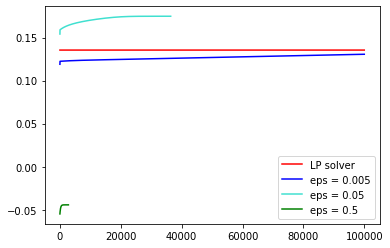

In [4]:
### test the accuracy of the algo compared to LP solver
if True :
    utils.plot_accuracy_algorithm(C, a, b)

In [5]:
def gen_word(num_samples):
    X, Y = utils.simul_two_Gaussians(num_samples)
    a = (1 / num_samples) * np.ones(num_samples)
    return X, Y, a, a

In [6]:
def run_simu_2(num_samples, num_agents, max_iter=50000, val_min=0, val_max=1, eps=5e-3):
    """Simulation de l'algorithme avec des signes fixes pour tous les agents"""
    
    assert np.exp(val_max/eps) < float('inf'), 'val max is too high with respect to eps'
    
    # Génération des points et des poids associés
    X, Y, a, b = gen_word(num_samples)
    
    # Génération des coûts
    C = np.random.uniform(val_min, val_max, (num_agents, num_samples, num_samples))
    
    # Génération des signes des couts
    C_signes = np.random.choice([-1, 1], (num_samples, num_samples))
    for i, c in enumerate(C):
        C[i] = np.multiply(c, C_signes)
        
    # Run algo
    return X, Y, C, eot.EOT_PSinkhorn(C, eps, a, b)

In [7]:
def diff_prc_simu_2(res_run_simu_2):
    """Return the max diff in pourcentage of the diff of the mean of price and price of players"""
    
    X, Y, C, all_res = res_run_simu_2
    alpha, beta, denom, _, K_trans = all_res[3:] 

    couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom
    price = np.array(utils.price_of_players(C, couplings))

    diff = np.abs(price.max() - price.min())
    
    return np.abs(diff/price.mean()) * 100

In [8]:
num_samples = 5
num_agents = 3
num_simu = 1000

simulations = [run_simu_2(num_samples, num_agents) for _ in range(num_simu)]
diff_res = [diff_prc_simu_2(res) for res in simulations]

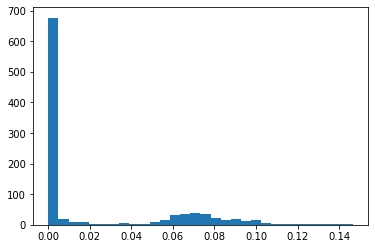

In [9]:
s = np.argsort(diff_res)
plt.hist(np.take(diff_res, s), 30)
plt.show()

In [10]:
res_pb = simulations[s[-1]]

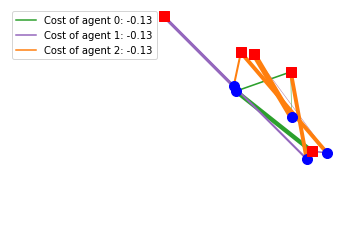

In [11]:
X, Y, C, all_res = res_pb
alpha, beta, denom, _, K_trans = all_res[3:] 

couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom

utils.print_ot_and_cost(X, Y, couplings, C)

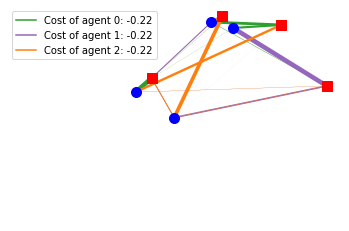

In [12]:
num_samples = 4

X, Y = utils.simul_two_Gaussians(num_samples)
a, b = (1 / num_samples) * np.ones(num_samples), (1 / num_samples) * np.ones(
    num_samples)

C1 = np.random.uniform(0,1,(num_samples,num_samples))
C2 = np.random.uniform(0,1,(num_samples,num_samples)) #square cost a la puissance alpha
C3 = np.random.uniform(0,1,(num_samples,num_samples)) # 0 si x=y et 1 sinon

Cp1 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))
Cp2 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))
Cp3 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))

C = np.zeros((3, num_samples, num_samples))
C[0, :, :] = np.multiply(C1,Cp1)
C[1, :, :] = np.multiply(C2,Cp2)
C[2, :, :] = np.multiply(C3,Cp3)
C[:,0,:]*=1

if False :
    for i, cost_matrix in enumerate(C):
        size_matrix = 1 + num_samples*(4+n_float)
        print(f"{f'Cost Matrix Agent {i}':^{size_matrix}}\n")
        print(cost_matrix, "\n")

# run the algo avec reg (epsilon) de 10**-3
reg = 5 * 1e-2
res, acc, lam, alpha, beta, denom, KC, K_trans = eot.EOT_PSinkhorn(C, reg, a, b)
# compute P and check that P satisfies the marginal constraints
#plt.plot(acc)
#plt.show()
couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom

utils.print_ot_and_cost(X, Y, couplings, C)

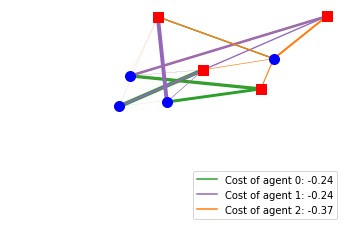

In [13]:
num_samples = 4

X, Y = utils.simul_two_Gaussians(num_samples)
a, b = (1 / num_samples) * np.ones(num_samples), (1 / num_samples) * np.ones(
    num_samples)

C1 = np.random.uniform(0,1,(num_samples,num_samples))
C2 = np.random.uniform(0,1,(num_samples,num_samples)) #square cost a la puissance alpha
C3 = np.random.uniform(0,1,(num_samples,num_samples)) # 0 si x=y et 1 sinon

Cp1 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))
Cp2 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))
Cp3 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))

C = np.zeros((3, num_samples, num_samples))
C[0, :, :] = np.multiply(C1,Cp1)
C[1, :, :] = np.multiply(C2,Cp2)
C[2, :, :] = C3*-3
C[:,0,:]*=1

if False :
    for i, cost_matrix in enumerate(C):
        size_matrix = 1 + num_samples*(4+n_float)
        print(f"{f'Cost Matrix Agent {i}':^{size_matrix}}\n")
        print(cost_matrix, "\n")

# run the algo avec reg (epsilon) de 10**-3
reg = 5 * 1e-2
max_iter = 4000
res, acc, lam, alpha, beta, denom, KC, K_trans = eot.EOT_PSinkhorn(C, reg, a, b)
# compute P and check that P satisfies the marginal constraints
#plt.plot(acc)
#plt.show()
couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom

utils.print_ot_and_cost(X, Y, couplings, C)

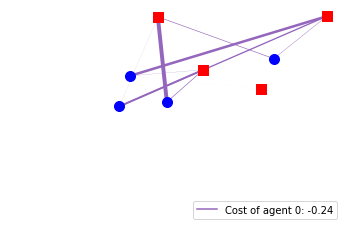

In [14]:
agent = 1
utils.print_ot_and_cost(X, Y, couplings, C, agent)

## BONUS

In [15]:
## Accelerated  PGD method
max_iter = 2000 # ne marche pas pour plus d'itérations !!!

reg_m = 5 * 1e-2
res_m, acc_m, times_m, lam_m, alpha_m, beta_m, denom_m, KC_m, K_trans_m = eot.EOT_APGD(C, reg_m, a, b, max_iter=max_iter)

reg_mm = 5* 1e-1
res_mm, acc_mm, times_m, lam_mm, alpha_mm, beta_mm, denom_mm, KC_mm, K_trans_mm = eot.EOT_APGD(C, reg_mm, a, b, max_iter=max_iter)

reg = 5 * 1e-3
res, acc, times_m, lam, alpha, beta, denom, KC, K_trans = eot.EOT_APGD(C, reg, a, b, max_iter=max_iter)

res_prim = eot.LP_solver_Primal(C, a, b)

eps = 1e-2
couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom

P1, P2, P3 = couplings
P = P1 + P2 + P3
# check that P satisfies the marginal constraints
#assert (np.sum(P, axis=0) - a < eps).all()
#assert (np.sum(P, axis=1) - b < eps).all()


plt.plot([res_prim["fun"]]*max_iter, c = "red", label = "LP solver")
plt.plot(acc,c="blue",label = "eps = 0.005")
plt.plot(acc_m,c="turquoise",label = "eps = 0.05")
plt.plot(acc_mm,c="green",label = "eps = 0.5")
plt.legend()
plt.show()

AttributeError: module 'EOT.EOT' has no attribute 'EOT_APGD'

In [ ]:
# Compute the primal formulation of the entropic EOT
res_primal = eot.compute_EOT_primal(lam, alpha, beta, KC, denom, reg, a, b)

print(res_primal)